# Email Spam Detection (Semi-supervised AD)

Esempio di tecniche di **Semi-supervised Anomaly Detection** sul dataset delle email di Enron! Per la parte di classificazione, consulta il notebook "Email Ham-Spam Classification". Enjoy! 😎


**N.B.** Questo notebook è un estratto!

## Get the data using Kaggle API

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"delpreales","key":"b44e7562e691d5b6a3494ddd5e4d9a57"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d "veleon/ham-and-spam-dataset"

 74% 9.00M/12.2M [00:00<00:00, 24.8MB/s]
100% 12.2M/12.2M [00:00<00:00, 30.9MB/s]


In [ ]:
!unzip 'ham-and-spam-dataset.zip'

## Data Loading

In [8]:
import pandas as pd
import numpy as np
import nltk
import os
import re
from gensim.models import Word2Vec

In [9]:
ds_dir = 'hamnspam'

def load_ds():
  mails = []
  labels = []
  for dir in os.listdir(ds_dir):
    for file in os.listdir(ds_dir+'/'+dir):
      mail = open(ds_dir+'/'+dir+'/'+file,'r', encoding='latin-1')
      text = mail.readlines()
      text = "".join(text)
      mails.append(text)
      labels.append(dir)
  return mails, labels

In [10]:
mails, labels = load_ds()

In [11]:
mails[0]

'From rssfeeds@jmason.org  Mon Oct  7 12:05:24 2002\nReturn-Path: <rssfeeds@example.com>\nDelivered-To: yyyy@localhost.example.com\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (Postfix) with ESMTP id CEBF516F49\n\tfor <jm@localhost>; Mon,  7 Oct 2002 12:04:01 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Mon, 07 Oct 2002 12:04:01 +0100 (IST)\nReceived: from dogma.slashnull.org (localhost [127.0.0.1]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g9780pK23313 for\n    <jm@jmason.org>; Mon, 7 Oct 2002 09:00:52 +0100\nMessage-Id: <200210070800.g9780pK23313@dogma.slashnull.org>\nTo: yyyy@example.com\nFrom: guardian <rssfeeds@example.com>\nSubject: Ministers issue gag orders for MI5 trial\nDate: Mon, 07 Oct 2002 08:00:51 -0000\nContent-Type: text/plain; encoding=utf-8\nX-Spam-Status: No, hits=-937.6 required=5.0\n\ttests=AWL,T_NONSENSE_FROM_40_50\n\tversion=2.50-cvs\nX-Spam-Lev

In [12]:
labels[0]

'ham'

## Pre-processing

In [13]:
new_mails=[]
for i in range(len(mails)):
  mails[i] = mails[i].strip()     # rimuovo blanks
  new_mails.append(mails[i].lower())  # converto tutto in formato lowercase

In [14]:
new_mails[0]

'from rssfeeds@jmason.org  mon oct  7 12:05:24 2002\nreturn-path: <rssfeeds@example.com>\ndelivered-to: yyyy@localhost.example.com\nreceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (postfix) with esmtp id cebf516f49\n\tfor <jm@localhost>; mon,  7 oct 2002 12:04:01 +0100 (ist)\nreceived: from jalapeno [127.0.0.1]\n\tby localhost with imap (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); mon, 07 oct 2002 12:04:01 +0100 (ist)\nreceived: from dogma.slashnull.org (localhost [127.0.0.1]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with esmtp id g9780pk23313 for\n    <jm@jmason.org>; mon, 7 oct 2002 09:00:52 +0100\nmessage-id: <200210070800.g9780pk23313@dogma.slashnull.org>\nto: yyyy@example.com\nfrom: guardian <rssfeeds@example.com>\nsubject: ministers issue gag orders for mi5 trial\ndate: mon, 07 oct 2002 08:00:51 -0000\ncontent-type: text/plain; encoding=utf-8\nx-spam-status: no, hits=-937.6 required=5.0\n\ttests=awl,t_nonsense_from_40_50\n\tversion=2.50-cvs\nx-spam-lev

## Tokenization

In [15]:
nltk.download('punkt')
from nltk import word_tokenize

for i in range(len(mails)):
  new_mails[i] = word_tokenize(new_mails[i])     # word tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
new_mails[0][0]

'from'

## Removing Stop-Words

In [17]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
from string import digits

sw = set(stopwords.words('english'))    # la verifica sugli insiemi è + veloce

# aggiungo al set di stopwords anche le punteggiature
sw = sw.union(set(punctuation))
# aggiungo la parola "subject" per rimuoverla 
sw = sw.union({'subject'})

for i in range(len(mails)):
    new_mails[i] = [word for word in new_mails[i] if word not in sw and not len(word)<=2
                    or word=='re' and len(set([char for char in word]).intersection(set([char for char in digits])))==0]    # rimuovo stopwords e sillabe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lemmatization

Per la lemmatizzazione uso **WordNet**, per cui vado prima a effettuare il **PoS tagging** (Part of Speech). 

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


def wordnet_tag(tagged_mail):

    wordnet_tag = {'NN':'n', 'JJ':'a',   # noun & adjective
                  'VB':'v', 'RB':'r'}   # verb & adverb
    try:
        return wordnet_tag[tagged_mail[:2]]
    except:
        return 'n'


wn = WordNetLemmatizer()
mails_tagged = []
for i in range(len(mails)):
    mails_tagged.append([wn.lemmatize(word, pos=wordnet_tag(tag)) for word, tag in pos_tag(new_mails[i])])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## SEMI-SUPERVISED ANOMALY DETECTION

**DESCRIZIONE DEL TASK**<br>L'anomaly detection semi-supervisionata prevede l'utilizzo di un modello addestrato sulla classe normale, in quanto si assume questa classe come conosciuta, mentre la classe anomala è ignota. Si seleziona come classe normale la classe più popolosa (ham) e come anomalie la classe spam.

La scelta della **rappresentazione** è fondamentale. Ad esempio, TD-IDF potrebbe far perdere informazioni significative per il riconoscimento degli spam, questo perché una rappresentazione basata sulla frequenza dei token non pone attenzione su termini poco frequenti ma molto significativi.<br> Per questo motivo si è scelto di usare una rappresentazione matriciale a dimensione **N*M**, dove N è il numero di email del dataset e M è la lunghezza massima delle email. Le feature della matrice corrispondono alla rappresentazione vettoriale delle singole email, cioè all’embedding di tutte le parole ottenute con Word2Vec. Tuttavia, per ridurre la complessità, si è scelto quindi di usare un word embedding di size 20 e di non includere nel vocabolario parole con frequenza inferiore a 10. Un’ulteriore semplificazione è stata effettuata ponendo il padding a 100, troncando quindi ogni email a dimensione 100. Questo perché la maggior parte delle email presenta meno di 100 token.

### Word2Vec Vocabulary

Creo una rappresentazione in cui ogni email è rappresentata dagli embedding delle sue parole.

In [19]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=20,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007)

w2v_model.build_vocab(mails_tagged, progress_per=10000)
w2v_model.train(mails_tagged, total_examples=w2v_model.corpus_count, epochs=20)
word_embedding = w2v_model[w2v_model.wv.vocab]

vocab = list(w2v_model.wv.vocab.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [20]:
embedded_ds = []
for mail in mails_tagged:
  embedding = []
  for i in set(mail):   # elimino i duplicati per ridurre la complessità
    if i in vocab:
      embedding.append(w2v_model[i])
  embedding = np.array(embedding)
  if len(embedding.shape) > 1:
    embedding = np.reshape(embedding, embedding.shape[0]*embedding.shape[1])
  embedded_ds.append(embedding)


embedded_np = np.array(embedded_ds)
print(embedded_np.shape)

# padding
from keras.preprocessing import sequence
pad_ds = sequence.pad_sequences(embedded_np, padding='post', dtype='float32', maxlen=100)
print(pad_ds.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


(3052,)
(3052, 100)


### Adapt data for AD

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [23]:
e_labels=np.array(labels)
e_labels[e_labels=='ham'] = 0
e_labels[e_labels=='spam'] = 1
e_labels = np.array(e_labels, dtype=np.int32)

normal = []
normal_labels = []
spam = []
spam_labels = []
for i in range(len(pad_ds)):
  if e_labels[i]==0:
    normal.append(pad_ds[i])
    normal_labels.append(e_labels[i])
  else:
    spam.append(pad_ds[i])
    spam_labels.append(e_labels[i])

normal = np.array(normal)
normal_labels = np.array(normal_labels)
spam = np.array(spam)
spam_labels = np.array(spam_labels, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(normal, normal_labels, test_size=0.3, random_state=42)
X_test = np.append(X_test, spam, axis=0)
y_test = np.append(y_test, spam_labels)

### **LSTM AutoEncoder**

Implemento un semplice **autoencoder** LSTM da addestrare sui dati normali. In questo modo, l'autoencoder sarà in grado di **ricostruire** bene email normali, mentre incontrerà difficoltà nel ricostruire email anomale!
Trovare un testo che l’autoencoder non è riuscito a ricostruire fedelmente significa trovarsi di fronte a uno **spam**!

In [24]:
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense, LSTM


timesteps = 1
n_features = 100

X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)


# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 100)            25700     
Total params: 1,114,212
Trainable params: 1,114,212
Non-trainable params: 0
______________________________________________

In [25]:
model.fit(X_train, X_train, epochs=20, batch_size=32)

Epoch 1/20
56/56 [==============================] - 6s 22ms/step - loss: 1.7863
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0967
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 0.8138
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 0.5464
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 0.4273
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 0.3444
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 0.3063
Epoch 8/20
56/56 [==============================] - 1s 20ms/step - loss: 0.2659
Epoch 9/20
56/56 [==============================] - 1s 21ms/step - loss: 0.2474
Epoch 10/20
56/56 [==============================] - 1s 20ms/step - loss: 0.2149
Epoch 11/20
56/56 [==============================] - 1s 20ms/step - loss: 0.2029
Epoch 12/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1859
Epoch 13/20
56/56 [==================

Per distinguere le email normali da quelle spam, usiamo uno score calcolato sugli **errori di ricostruzione** dei samples. Lo score di outlierness è stato calcolato con la distanza di Chebyshev.



1.   Usiamo l'autoencoder per ricostruire gli esempi del test set:



In [26]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

y_pred = model.predict(X_test)


2.   Calcoliamo lo score di outlierness:



In [27]:
score = []
for i in range(len(y_test)):
    score.append(np.mean(abs(y_test[i]-y_pred[i])))

## Spam Detection Results

Confrontiamo le distribuzioni dei sample originali e delle ricostruzioni:

In [28]:
# metodi di utilità
!mkdir plots
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join('plots/', fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

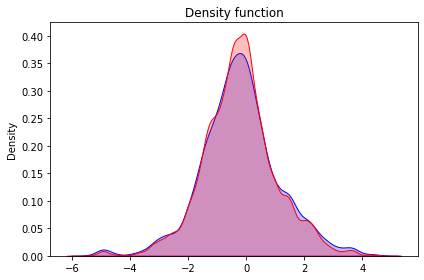

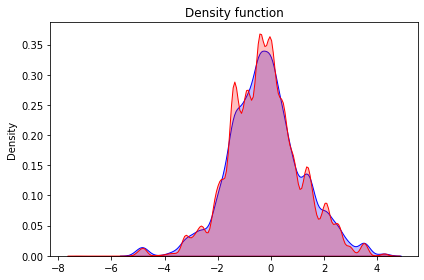

In [30]:
import seaborn as sns

plt.figure()
ax1 = sns.distplot(y_pred[:123] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='ham',color="blue")
ax2 = sns.distplot(y_pred[124:] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='spam', color= "red")

plt.title('Density function')
save_fig('pred_density')

plt.figure()
ax1 = sns.distplot(X_test[:123] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='ham',color="blue")
ax2 = sns.distplot(X_test[124:] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='spam', color= "red")

plt.title('Density function')
save_fig('real_density')

Curva **ROC**

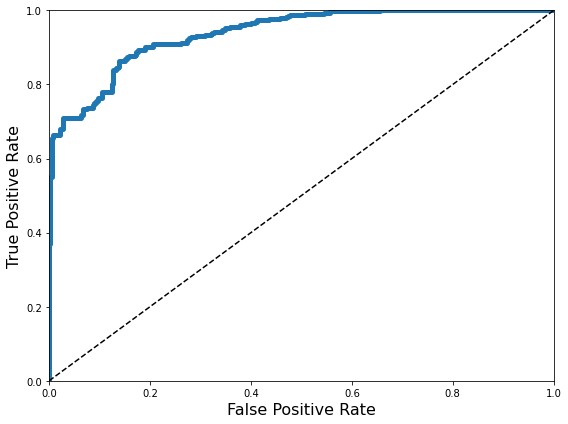

In [33]:
from sklearn import metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, score)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig('ROC')

Calcolo **AUC**

In [34]:
metrics.auc(fpr, tpr)

0.9382410114496855

🔝🔝🔝